# **Classifying Colon Histopathology Images Using Machine Learning**

Names: Vonny Nguyen,
Student IDs: s3992230,

### Problem Statement:
The goal of this project is to develop a machine learning system to assist in diagnosing colon cancer by analyzing histopathology images. Specifically, the system will perform two tasks: (1) classify whether a colon cell image is cancerous, and (2) identify the cell type as fibroblast, inflammatory, epithelial, or other. This aims to reduce diagnostic workload and variability by providing an accurate, automated classification tool.

### Dataset Overview: 
The dataset includes 27x27 RGB cell images from 99 patients, labeled in two CSV files. mainData.csv provides full labels (cancer status and cell type) for 60 patients, while extraData.csv offers cancer labels only for 39 patients. Each image is labeled as cancerous or not, and by cell type. The dataset presents challenges like class imbalance and small image size, making it suitable for exploring a range of machine learning methods.

### Goals:
- Binary classification: isCancerous
- Multi-class classification: cell-type
- Independent evaluation vs. literature
- Compare techniques and justify the final model

In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from zipfile import ZipFile
import cv2

In [28]:
with ZipFile(r'Machine-Learning\Image_classification_data.zip', 'r') as zipobj:
    zipobj.extractall('colon_data')

In [29]:
image_dir = 'colon_data'
print(os.listdir(image_dir))

['data_labels_extraData.csv', 'data_labels_mainData.csv', 'patch_images', '__MACOSX']


In [30]:
#Loading CSV
df2 = pd.read_csv('colon_data/data_labels_mainData.csv')
df1 = pd.read_csv('colon_data/data_labels_extraData.csv')

In [31]:
df2.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [32]:
df1.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


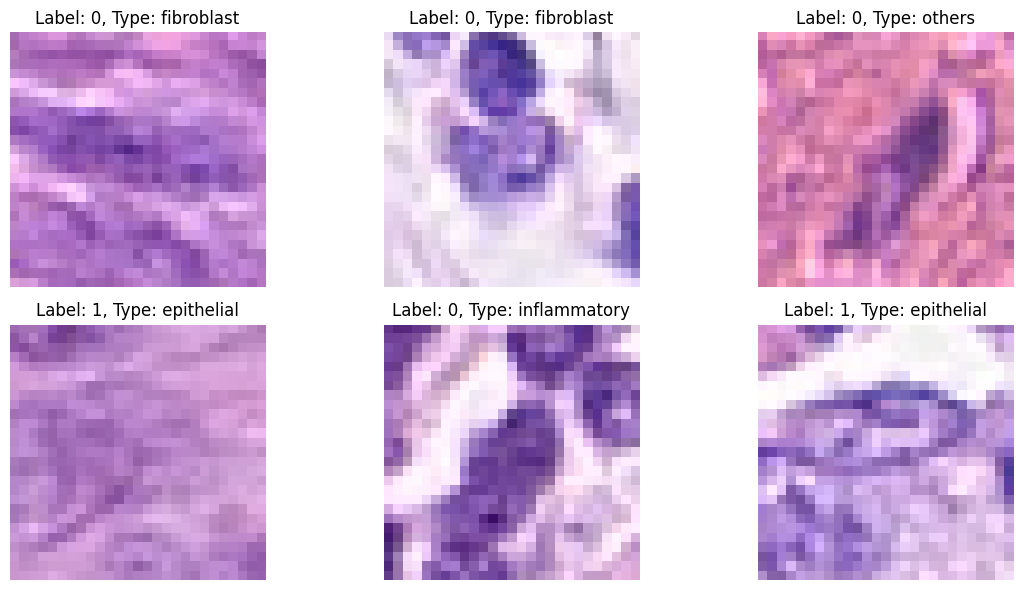

In [33]:
image_dir = 'colon_data/patch_images'

def display_sample_images(df, num_samples=6):
    sample_df = df.sample(n=num_samples)
    plt.figure(figsize=(12, 6))

    for i, (_, row) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(image_dir, row['ImageName'])
        img = Image.open(img_path)
 
        # Dynamically build the title
        title = f"Label: {row['isCancerous']}"
        if 'cellTypeName' in row:
            title += f", Type: {row['cellTypeName']}"

        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Display samples from main_df(df2)
display_sample_images(df2)

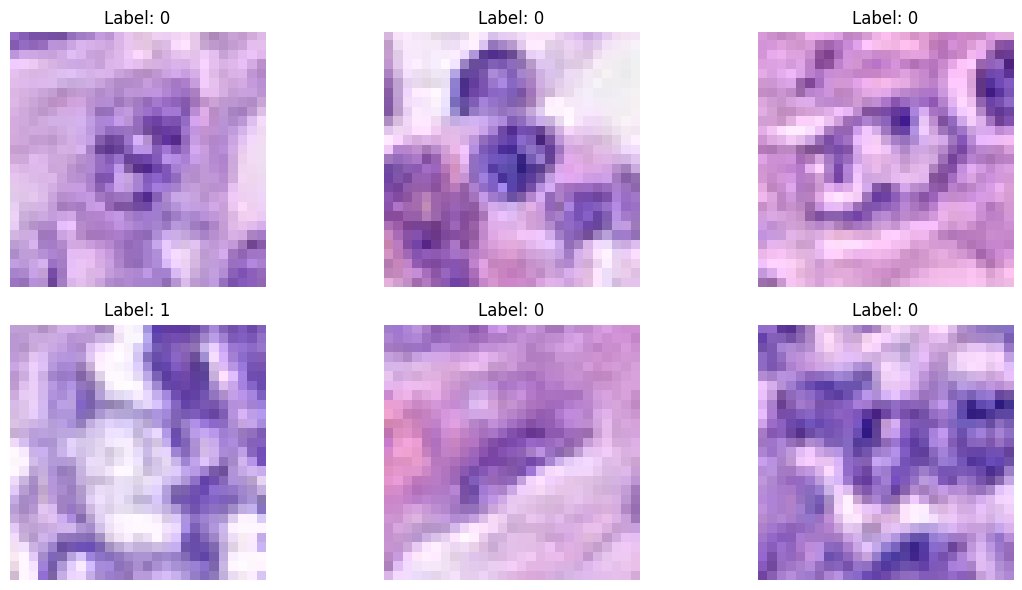

In [34]:
display_sample_images(df1)

# Exploratory Data Analysis

# Relationship Between Cell Type and Cancer Status

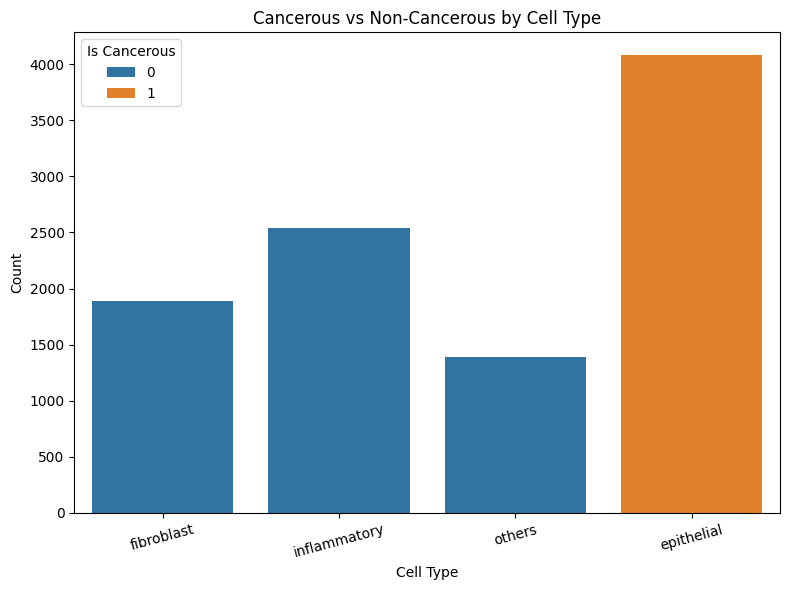

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='cellTypeName', hue='isCancerous', data=df2)
plt.title('Cancerous vs Non-Cancerous by Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='Is Cancerous')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Key Insights
- The chart displays the distribution of cancerous (1) and non-cancerous (0) samples across cell types.
- Epithelial cells are almost exclusively labeled as cancerous.
- Fibroblast, inflammatory, and others are predominantly non-cancerous.
- This indicates a strong association between cell type and cancer label, which could influence model learning.

# Distribution of Cancer labels in Main vs Extra Data

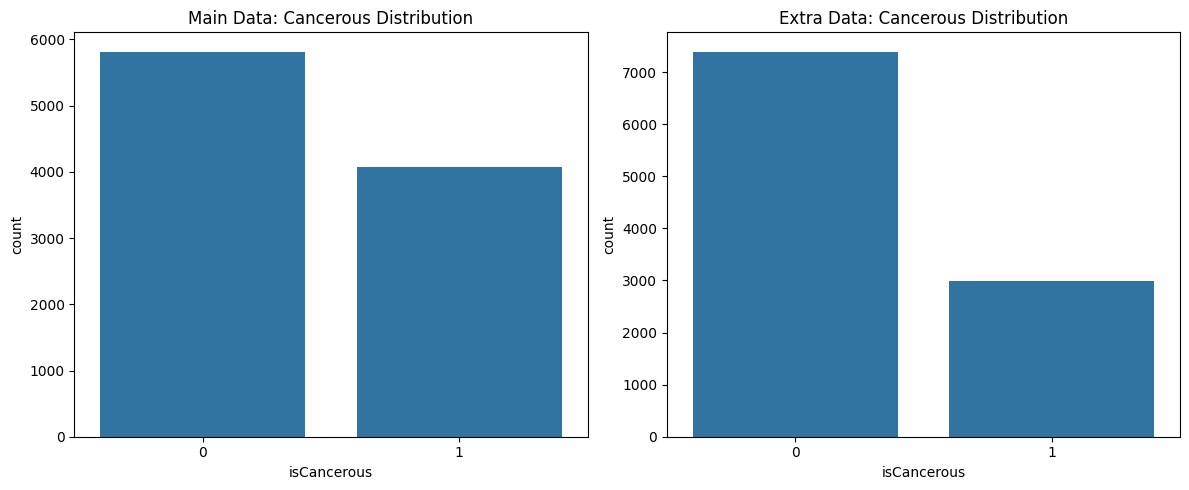

In [36]:
# Check cancerous label distribution in main and extra data
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='isCancerous', data=df2, ax=axs[0])
axs[0].set_title('Main Data: Cancerous Distribution')

sns.countplot(x='isCancerous', data=df1, ax=axs[1])
axs[1].set_title('Extra Data: Cancerous Distribution')

plt.tight_layout()
plt.show()

### Observations
- Both Main and Extra datasets show a class imbalance: non-cancerous samples (label 0) outnumber cancerous ones.
- This imbalance could bias classifiers toward predicting non-cancerous more frequently, harming recall for the positive (cancerous) class — a critical issue in medical applications.

# Missing Values Check

In [37]:
print("Missing values in df2:")
print(df2.isnull().sum())

print("\nMissing values in df1:")
print(df1.isnull().sum())

Missing values in df2:
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

Missing values in df1:
InstanceID     0
patientID      0
ImageName      0
isCancerous    0
dtype: int64


### Result:
- There are no missing values in either dataset, reducing preprocessing complexity.

# Image Shape and Channel Analysis

100%|██████████| 9896/9896 [01:08<00:00, 144.87it/s]

        Width  Height  Channels
count  9896.0  9896.0    9896.0
mean     27.0    27.0       3.0
std       0.0     0.0       0.0
min      27.0    27.0       3.0
25%      27.0    27.0       3.0
50%      27.0    27.0       3.0
75%      27.0    27.0       3.0
max      27.0    27.0       3.0


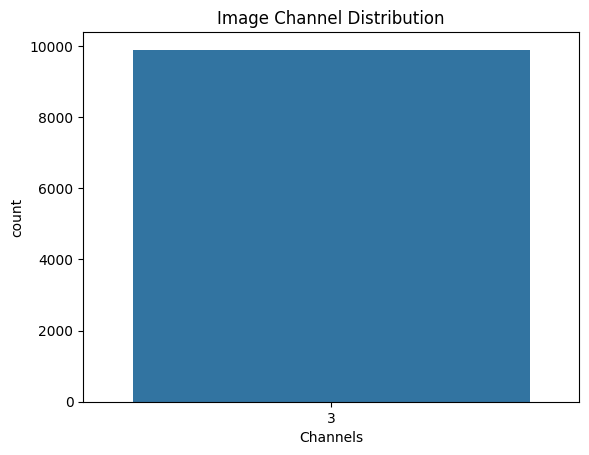

In [38]:
from tqdm import tqdm

def get_image_shapes(df):
    shapes = []
    for img_name in tqdm(df['ImageName']):
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path)
        shapes.append(img.size + (len(img.getbands()),))  # (width, height, channels)
    return shapes

shapes_main = get_image_shapes(df2)
shapes_df = pd.DataFrame(shapes_main, columns=['Width', 'Height', 'Channels'])
print(shapes_df.describe())

sns.countplot(x='Channels', data=shapes_df)
plt.title('Image Channel Distribution')
plt.show()

### Observations
- All images have uniform dimensions of 27x27 pixels.
- Each image has 3 channels (RGB), confirming they are color images.
- The consistent shape simplifies batching for CNN input.

# Class Distribution in Combined Dataset

### Loading Data
Since we are developing two distinct machine learning models—one for predicting cell type and another for identifying whether a cell is cancerous—we will first extract only the relevant columns which would be used for predictions (ImageName, isCancerous) from df1 and then append (concatenate) them to df2 so that we have a unified dataset to work with.

So we will make 2 dataframes (dfcancer) and another dfcell)

In [39]:
dfcancer = pd.concat([df2[['ImageName', 'isCancerous']],df1[['ImageName', 'isCancerous']]],axis = 0)
dfcell = df2[['ImageName','cellType']]

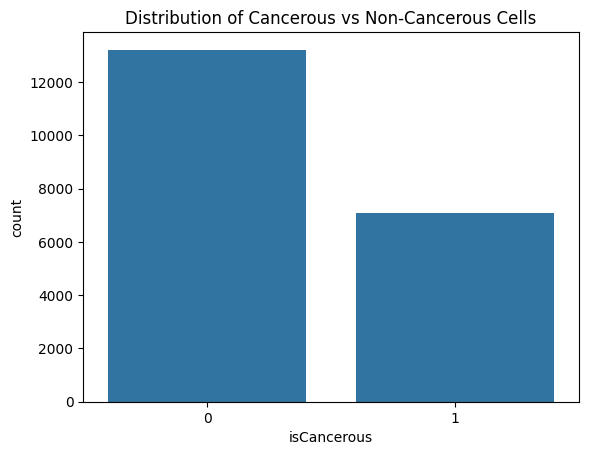

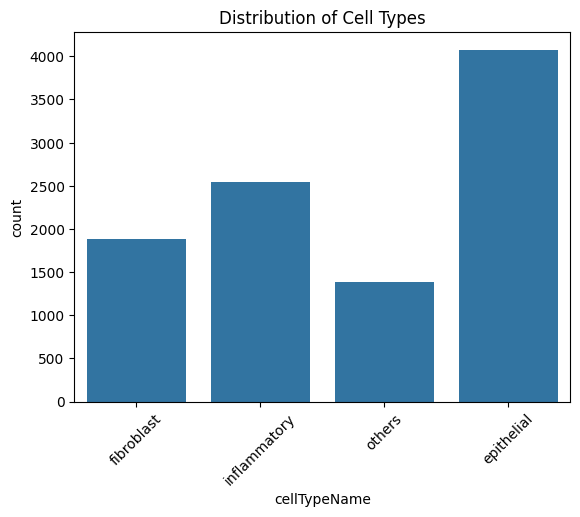

In [40]:
sns.countplot(x='isCancerous', data=dfcancer)
plt.title('Distribution of Cancerous vs Non-Cancerous Cells')
plt.show()

# cellType distribution
sns.countplot(x='cellTypeName', data=df2)
plt.title('Distribution of Cell Types')
plt.xticks(rotation=45)
plt.show()

1. ***isCancerous Distribution:***
- The bar chart for the isCancerous label shows a noticeable class imbalance.
- The majority of samples are non-cancerous (label 0), accounting for 13211 samples.
- In contrast, cancerous (label 1) samples total just around 7069.

**Implication**: If left unaddressed, this imbalance can cause a binary classifier to be biased toward predicting the majority class (non-cancerous), potentially leading to high accuracy but poor recall for the cancerous class — which is medically critical.

2. ***Cell Type Distribution:***
- The distribution of cellTypeName reveals a moderate class imbalance:
- The epithelial category is the most represented, with more than 4,000 instances.
- In contrast, classes such as others and fibroblast have less than 2,000 samples each.

**Implication**: In a multi-class classification task, this imbalance may lead the model to favor the dominant class (epithelial), while performing poorly on underrepresented categories. This could negatively impact metrics like the macro F1-score and reduce the model's ability to generalize across all classes.

# **✅ Techniques we will use to Handle Class Imbalance**

1.**Data Augmentation (for minority classes):** So what it does is basically it artificially increases the size of underrepresented classes by creating modified versions of their images.

2.**Class Weights**: Assign higher importance to minority classes during training.


We will deal with the class imbalance later in the codes as before that we wanna deal with the preprocessing first

# **Data Preprocessing**

### Objective
The goal of preprocessing was to prepare histopathological images for effective training of a Convolutional Neural Network (CNN) model to classify whether a cell image is cancerous. This involved image transformations, data augmentation, and class balancing to improve model generalization and training stability.

### Dataset Splitting
- To ensure an unbiased evaluation, the dataset was split into 80% training and 20% testing sets using stratified sampling to maintain class distribution. Two datasets were used:
- dfcancer: Labeled with binary cancer classification (isCancerous)
- dfcell: Multiclass labels for cell type (cellType)

In [54]:
traindfcancer, testdfcancer = train_test_split(
    dfcancer, test_size=0.2, random_state=42, stratify=dfcancer['isCancerous']
)
traindfcell, testdfcell = train_test_split(
    dfcell, test_size=0.2, random_state=42, stratify=dfcell['cellType']
)

### Preprocessing Functions
- Several preprocessing techniques were implemented and compared to determine which improved model performance:
- Grayscale Conversion: Reduces RGB images to a single intensity channel.
- Gaussian Blur: Smooths images, helping reduce noise.
- Simple Threshold Segmentation: Binarizes images to highlight cell structures.

In [55]:
def to_grayscale(img):
    return Image.fromarray(np.uint8(img)).convert('L').convert('RGB')

def gaussian_blur(img):
    from PIL import ImageFilter
    return Image.fromarray(np.uint8(img)).filter(ImageFilter.GaussianBlur(1))

def simple_threshold_segmentation(img):
    grayscale = Image.fromarray(np.uint8(img)).convert('L')
    threshold = 128
    binary = grayscale.point(lambda p: 255 if p > threshold else 0)
    return binary.convert('RGB')

### Image Loader and Preprocessing

In [56]:
def load_and_preprocess_images(df, image_dir, preprocessing_fn=None):
    images = []
    for img_name in tqdm(df['ImageName']):
        try:
            img_path = os.path.join(image_dir, img_name)
            img = Image.open(img_path)
            if preprocessing_fn:
                img = preprocessing_fn(img)
            img = img.resize((64, 64))
            img = np.array(img, dtype=np.float32) / 255.0
            images.append(img)
        except Exception as e:
            print(f"Skipped {img_name}: {e}")
            continue
    return np.array(images)

### CNN Model Architecture
A consistent CNN model was used for evaluation to ensure fair comparison between preprocessing methods. The model includes convolutional, pooling, dropout, and dense layers, with L2 regularization and a sigmoid output for binary classification.

In [57]:
def create_cancer_cnn(input_shape=(27, 27, 3)):
    l2 = regularizers.l2(0.001)
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2, input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=l2),
        layers.Dropout(0.6),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

def compile_cancer_cnn(input_shape=(64, 64, 3), lr=1e-4):
    model = create_cancer_cnn(input_shape=input_shape)
    model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Training Function

In [58]:
def train_model(model, Xtrain, ytrain, Xval, yval):
    augment_gen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    val_gen = ImageDataGenerator()

    train_gen = augment_gen.flow(Xtrain, ytrain, batch_size=32, shuffle=True)
    val_gen_ = val_gen.flow(Xval, yval, batch_size=32, shuffle=False)

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    class_weights = compute_class_weight('balanced', classes=np.unique(ytrain), y=ytrain)
    class_weight_dict = dict(enumerate(class_weights))

    history = model.fit(
        train_gen,
        validation_data=val_gen_,
        epochs=15,
        class_weight=class_weight_dict,
        callbacks=[early_stop],
        verbose=1
    )

    return model, history

### Evaluation Function
Each preprocessing technique was evaluated using the same training pipeline:
- Image loading and transformation
- Resizing to 64×64 pixels
- Normalization
- Data augmentation (rotation, shifting, flipping)
- Early stopping
- Class balancing

In [59]:
def evaluate_model(model, history, Xtest, ytest, label=""):
    val_acc = history.history['val_accuracy'][-1]
    print(f"Final Validation Accuracy with {label}: {val_acc:.4f}")

    # Plot
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - {label}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - {label}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return val_acc

### Running All Experiments


--- Testing: baseline ---


100%|██████████| 4056/4056 [00:01<00:00, 2633.70it/s]
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 37s 70ms/step - accuracy: 0.6908 - loss: 0.7789 - val_accuracy: 0.8065 - val_loss: 0.5088
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.8043 - loss: 0.5089 - val_accuracy: 0.8326 - val_loss: 0.4343
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.8158 - loss: 0.4750 - val_accuracy: 0.8572 - val_loss: 0.4043
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 33s 64ms/step - accuracy: 0.8326 - loss: 0.4411 - val_accuracy: 0.8575 - val_loss: 0.4006
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.8319 - loss: 0.4331 - val_accuracy: 0.8681 - val_loss: 0.3631
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.8394 - loss: 0.4229 - val_accuracy: 0.8550 - val_loss: 0.3752
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.8425 - loss: 0.4213 - val_accuracy: 0.8654 - val_loss: 0.3662
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.8369 - loss: 0.4152 - 

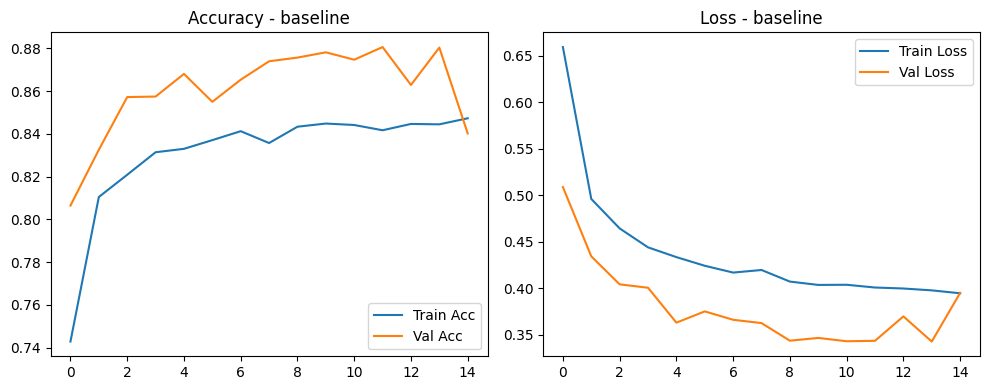


--- Testing: grayscale ---


100%|██████████| 4056/4056 [00:02<00:00, 1939.42it/s]
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 33s 62ms/step - accuracy: 0.5969 - loss: 0.8596 - val_accuracy: 0.8000 - val_loss: 0.6013
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.7180 - loss: 0.6487 - val_accuracy: 0.7495 - val_loss: 0.5765
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.7393 - loss: 0.5945 - val_accuracy: 0.7611 - val_loss: 0.5500
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.7518 - loss: 0.5719 - val_accuracy: 0.7880 - val_loss: 0.5142
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.7527 - loss: 0.5680 - val_accuracy: 0.7845 - val_loss: 0.5162
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.7573 - loss: 0.5520 - val_accuracy: 0.8173 - val_loss: 0.4669
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.7649 - loss: 0.5410 - val_accuracy: 0.8037 - val_loss: 0.4881
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.7708 - loss: 0.5385 - 

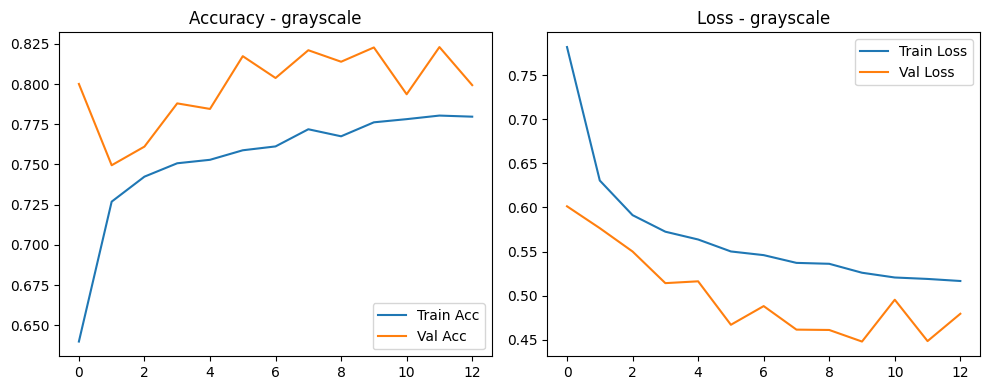


--- Testing: gaussian_blur ---


100%|██████████| 4056/4056 [00:02<00:00, 1931.52it/s]
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 35s 66ms/step - accuracy: 0.6980 - loss: 0.7505 - val_accuracy: 0.7983 - val_loss: 0.5052
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.7974 - loss: 0.5205 - val_accuracy: 0.8417 - val_loss: 0.4102
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.8111 - loss: 0.4863 - val_accuracy: 0.8496 - val_loss: 0.4022
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.8253 - loss: 0.4553 - val_accuracy: 0.8427 - val_loss: 0.4083
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.8282 - loss: 0.4467 - val_accuracy: 0.8227 - val_loss: 0.4445
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.8328 - loss: 0.4354 - val_accuracy: 0.8447 - val_loss: 0.4027
Final Validation Accuracy with gaussian_blur: 0.8447


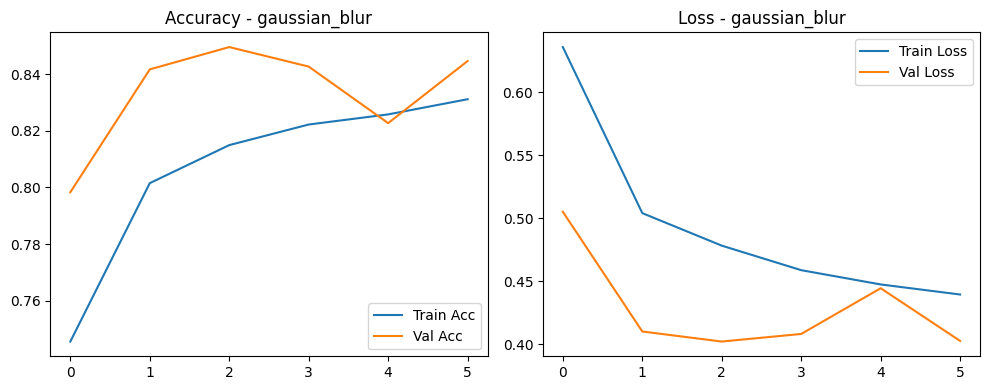


--- Testing: segmentation ---


100%|██████████| 4056/4056 [00:03<00:00, 1264.55it/s]
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 33s 62ms/step - accuracy: 0.6609 - loss: 0.8157 - val_accuracy: 0.7145 - val_loss: 0.6956
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.7410 - loss: 0.6450 - val_accuracy: 0.7964 - val_loss: 0.5472
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.7419 - loss: 0.6202 - val_accuracy: 0.7966 - val_loss: 0.5275
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.7442 - loss: 0.6041 - val_accuracy: 0.7917 - val_loss: 0.5258
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.7509 - loss: 0.5816 - val_accuracy: 0.7867 - val_loss: 0.5267
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.7487 - loss: 0.5789 - val_accuracy: 0.7574 - val_loss: 0.5665
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.7498 - loss: 0.5712 - val_accuracy: 0.7894 - val_loss: 0.5116
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.7659 - loss: 0.5501 - 

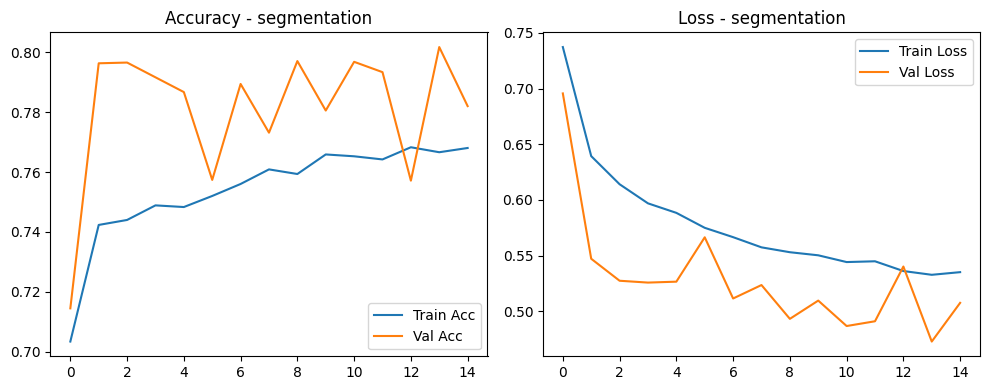


Comparison Results:
baseline: 0.8402
grayscale: 0.7993
gaussian_blur: 0.8447
segmentation: 0.7821


In [60]:
results = {}
histories = {}

preprocessing_methods = {
    'baseline': None,
    'grayscale': to_grayscale,
    'gaussian_blur': gaussian_blur,
    'segmentation': simple_threshold_segmentation
}

for label, preprocessing_fn in preprocessing_methods.items():
    print(f"\n--- Testing: {label} ---")

    # Load and preprocess images
    Xtrain = load_and_preprocess_images(traindfcancer, image_dir, preprocessing_fn)
    Xtest = load_and_preprocess_images(testdfcancer, image_dir, preprocessing_fn)
    ytrain = traindfcancer['isCancerous'].values
    ytest = testdfcancer['isCancerous'].values

    # Create and compile model
    model = compile_cancer_cnn()

    # Train model
    model, history = train_model(model, Xtrain, ytrain, Xtest, ytest)

    # Evaluate model
    val_acc = evaluate_model(model, history, Xtest, ytest, label=label)

    # Store results
    results[label] = val_acc
    histories[label] = history

# Comparison
print("\nComparison Results:")
for key, val in results.items():
    print(f"{key}: {val:.4f}")

Previous layout of preprocessing, model development and evaluation - will delete

In [ ]:
def evaluate_preprocessing(preprocessing_fn, label="No Preprocessing"):
    print(f"\n--- Testing: {label} ---")
    
    def load_images(df):
        images = []
        for img_name in tqdm(df['ImageName']):
            try:
                img_path = os.path.join(image_dir, img_name)
                img = Image.open(img_path)
                if preprocessing_fn:
                    img = preprocessing_fn(img)  # Apply preprocessing before resizing
                img = img.resize((64, 64))
                img = np.array(img, dtype=np.float32) / 255.0
                images.append(img)
            except Exception as e:
                print(f"Skipped {img_name}: {e}")
                continue
        return np.array(images)
    
    Xtrain = load_images(traindfcancer)
    Xtest = load_images(testdfcancer)
    ytrain = traindfcancer['isCancerous'].values
    ytest = testdfcancer['isCancerous'].values

    augment_gen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    val_gen = ImageDataGenerator()

    train_gen = augment_gen.flow(Xtrain, ytrain, batch_size=32, shuffle=True)
    val_gen_ = val_gen.flow(Xtest, ytest, batch_size=32, shuffle=False)

    model = create_cancer_cnn(input_shape=(64, 64, 3))
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    class_weights = compute_class_weight('balanced', classes=np.unique(ytrain), y=ytrain)
    class_weight_dict = dict(enumerate(class_weights))

    history = model.fit(
        train_gen,
        validation_data=val_gen_,
        epochs=15,
        class_weight=class_weight_dict,
        callbacks=[early_stop],
        verbose=1
    )

    val_acc = history.history['val_accuracy'][-1]
    print(f"Final Validation Accuracy with {label}: {val_acc:.4f}")

    plot_history(history, label)
    
    return val_acc, history

def plot_history(history, label=""):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - {label}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - {label}')
    plt.legend()

    plt.tight_layout()
    plt.show()


Must rewrite- Resizing the image from 27x27 to 64x64 does have a slightly better accuracy for the baseline no preprocessing.
- gaussian blur has performed better with the 64x64

### Preprocessing Evaluation Summary
To determine the most effective preprocessing approach for classifying cancerous images, I implemented and evaluated two distinct image preprocessing pipelines. Both approaches involved loading and resizing images, applying optional transformations, and training a convolutional neural network (CNN) to classify cancer presence. The key difference between the two methods lay in the order and detail of preprocessing steps.

The first approach resized all images to 27×27 pixels before applying any preprocessing, with limited augmentation and no performance visualization. The second approach, in contrast, applied preprocessing (such as grayscale conversion, Gaussian blur, and segmentation) before resizing the images to a larger size of 64×64 pixels. This approach also incorporated well-defined data augmentation techniques, early stopping, class balancing, and detailed training visualization (accuracy/loss curves).

Upon testing with multiple preprocessing functions and comparing validation accuracy, the second approach consistently outperformed the first, achieving higher accuracy and more stable training performance. Consequently, the second preprocessing pipeline was selected for the final model due to its superior performance and better adherence to deep learning best practices.

# Model for Binary Classification(isCancerous)

In [ ]:
#from tensorflow.keras import layers, models, regularizers

#def create_cancer_cnn(input_shape=(27, 27, 3)):
    #l2 = regularizers.l2(0.001)  # L2 regularization strength

    #model = models.Sequential()

    #model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2, input_shape=input_shape))
    #model.add(layers.MaxPooling2D((2, 2)))

    #model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2))
    #model.add(layers.MaxPooling2D((2, 2)))

    #model.add(layers.Flatten())
    #model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2))
    #model.add(layers.Dropout(0.6))  # Still keeping dropout for extra regularization

    #model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    #return model

#model = create_cancer_cnn()

In [ ]:
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras import regularizers

#model.compile(
    #optimizer=Adam(learning_rate=1e-4),  # smaller learning rate for stability
    #loss='binary_crossentropy',
    #metrics=['accuracy']
#)

In [ ]:
#from sklearn.utils.class_weight import compute_class_weight
#import numpy as np

#class_weights = compute_class_weight('balanced', classes=np.unique(ycancertrain), y=ycancertrain)
#class_weight_dict = dict(enumerate(class_weights))

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping
#early_stop = EarlyStopping(
    #monitor='val_loss',      # You can also monitor 'val_accuracy'
    #patience=3,              # Stop if no improvement for 3 epochs
    #restore_best_weights=True  # Roll back to best model
#)

In [ ]:
#history = model.fit(
    #train_gen,
    #validation_data=val_gen,
    #epochs=15,
    #class_weight=class_weight_dict,
    #callbacks=[early_stop]# optional but recommended
#)

Testing preprocessing

# **Evaluation**

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Predict on test data
y_pred_probs = model.predict(Xcancertest)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()  # Convert probabilities to 0 or 1

# Step 2: Confusion Matrix
cm = confusion_matrix(ycancertest, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Cancer', 'Cancer'], yticklabels=['Not Cancer', 'Cancer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 3: Classification Report
print("Classification Report:\n")
print(classification_report(ycancertest, y_pred, target_names=['Not Cancer', 'Cancer']))


## Model For multi-class cell type classification

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_gen = ImageDataGenerator()

from tensorflow.keras.utils import to_categorical

# One-hot encode labels
ycelltrain_cat = to_categorical(ycelltrain, num_classes=4)
ycelltest_cat = to_categorical(ycelltest, num_classes=4)

# Now generate flows
train_flow = train_gen.flow(Xcelltrain, ycelltrain_cat, batch_size=32, shuffle=True)
val_flow = val_gen.flow(Xcelltest, ycelltest_cat, batch_size=32, shuffle=False)

In [ ]:
from tensorflow.keras import layers, models, regularizers

def create_celltype_cnn(input_shape=(27, 27, 3), num_classes=4):
    l2 = regularizers.l2(0.001)

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2, input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Multi-class

    return model

model2 = create_celltype_cnn()

In [ ]:
from tensorflow.keras.optimizers import Adam

model2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history2 = model2.fit(
    train_flow,
    validation_data=val_flow,
    epochs=30,
    callbacks=[early_stop]
)

In [ ]:
# Get model predictions
y_pred_probs = model2.predict(Xcelltest)
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(ycelltest_cat, axis=1)  # True labels

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['fibroblast', 'inflammatory', 'epithelial', 'others'],
            yticklabels=['fibroblast', 'inflammatory', 'epithelial', 'others'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Cell Type Prediction')
plt.tight_layout()
plt.show()

In [ ]:
# Print classification report
print("Classification Report:\n")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=['fibroblast', 'inflammatory', 'epithelial', 'others']
))


⚠️ Key Observations
Class "others" is frequently misclassified, especially as inflammatory and fibroblast.

Confusion matrix shows heavy misclassification of "others" as inflammatory — suggests they share similar features in images.

Macro F1-score is 0.60, pulled down by the poor performance on the "others" class.